# Pràctica 1 - El procés de l'aprenentatge automàtic:

### Autors:
- Xisco Cerdó Bibiloni
- Gerard Mediana Martorell

## Imports

In [34]:
import os
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from skimage import io
from skimage.transform import resize
from skimage.color import rgb2gray
import numpy as np
from skimage.feature import hog
from skimage import exposure
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import joblib

## Funció de càrrega d'imatges

In [26]:
def load_images(folder_path, target_size=(128, 128)):
    images = []
    labels = []
    
    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image = io.imread(image_path)
            
            # Reescalar
            image = resize(image, target_size)
            # Passar a grisos
            if image.ndim == 2:
                gray_image = image
            else:
                gray_image = rgb2gray(image)
            
            images.append(gray_image)
            labels.append(label)
    
    return np.array(images), np.array(labels)

## Funció HOG

In [27]:
def hog_images(images, hog_orientations=9, hog_pixels_per_cell=(16, 16), hog_cells_per_block=(8, 8), mostrar=False):
    hog_features = []
    hog_images_rescaled = []
    for image in images:
        if(mostrar):
            # Compute HOG features
            hog_feature, hog_image = hog(image, orientations=hog_orientations,
                                        pixels_per_cell=hog_pixels_per_cell,
                                        cells_per_block=hog_cells_per_block,
                                        block_norm='L2-Hys', visualize=True)
            hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
            hog_images_rescaled.append(hog_image_rescaled)
        else:
            hog_feature = hog(image, orientations=hog_orientations,
                                        pixels_per_cell=hog_pixels_per_cell,
                                        cells_per_block=hog_cells_per_block,
                                        block_norm='L2-Hys', visualize=False)
            hog_features.append(hog_feature.flatten())
            
    if(mostrar):
        return np.array(hog_features), np.array(hog_images_rescaled)
    else:
        return np.array(hog_features)

## Càrrega de dades

In [28]:
# Carregar imatges
train_path = 'dat/train/'
test_path = 'dat/test/'
print("Carregant imatges")
X_train, y_train = load_images(train_path)
print(f"{X_train.shape} train imatges")
X_test, y_test = load_images(test_path)
print(f"{X_test.shape} test imatges")

Carregant imatges


(1500, 128, 128) train imatges
(2985, 128, 128) test imatges


## HOG

In [29]:
# Processar imatges train
print("Processant imatges train")
mostrar = False
if(mostrar):
    X_train_hog, hog_train_images = hog_images(X_train, mostrar=True)
    # Mostrar hogs
    unique_labels = np.unique(y_train)

    for label in unique_labels:
        index = np.where(y_train == label)[0][0]
        plt.imshow(hog_train_images[index], cmap='gray')
        plt.title(f'HOG Image Rescaled - Label: {label}')
        plt.show()

else:
    X_train_hog = hog_images(X_train, mostrar=False)
print(f"{X_train.shape} imatges train processades")

# Processar imatges test
print("Processant imatges test")
X_test_hog = hog_images(X_test, mostrar=False)
print(f"{X_test.shape} imatges test processades")

Processant imatges train
(1500, 128, 128) imatges train processades
Processant imatges test
(2985, 128, 128) imatges test processades


## Normalització de les dades

In [35]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)
print("Imatges escalades")

Imatges escalades


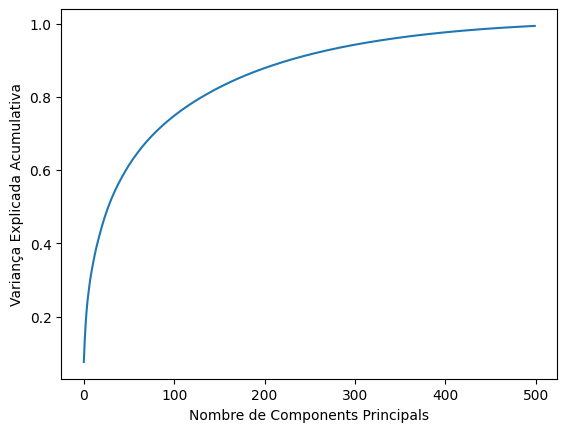

Number of components to capture at least 92% of the variance: 259


In [92]:
# Mostrar PCA
n_components = 500
pca = PCA(n_components=n_components)
pca.fit_transform(X_train_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_explained_variance)
plt.xlabel('Nombre de Components Principals')
plt.ylabel('Variança Explicada Acumulativa')
plt.show()

pca = PCA()
pca.fit_transform(X_train_scaled)


# Calcular la varianaça explicada
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Trobam el nombre de components que capturen almenos un 92 % de variança
desired_explained_variance = 0.92
n_components_92 = np.argmax(cumulative_explained_variance >= desired_explained_variance) + 1

print(f"Number of components to capture at least 92% of the variance: {n_components_92}")

# PCA per 276 components (0.92% de components que expliquen sa variança)
pca = PCA(n_components=276)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

## Entrenament i test dels SVM

### Grid Search

In [36]:
svm = SVC()
param_grid = {
    'C': [0.1, 1, 1.5 , 10], # Parametre de regularitzacio
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.001, 0.01, 0.1] # Coeficient de Kernel
}
grid_search = GridSearchCV(svm, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Dataset amb el millor estimador
best_svm_model = grid_search.best_estimator_
model_path = 'dat/best_svm_model.joblib'
joblib.dump(best_svm_model, model_path)

best_svm_model.fit(X_train_scaled, y_train)
print("Model entrenat")
y_pred = best_svm_model.predict(X_test_scaled)

# Evaluació model
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cf_matrix)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Model entrenat
Confusion matrix:
 [[ 53   5   0   4   1   0   6   0   0   2   8   0  13  23   1]
 [  4  78   0   1   1   0   2   0   0   1   8   4   9   7   0]
 [  2   2 217   7   1   3   0  37   8   7   2   0   0   0  24]
 [  2   0  10 113   1   4  13   2  11   1   9  18   7  12  12]
 [  1   2   1   4 151   2   2   0   0   3  17   5   3   0   1]
 [  1   1   3   2   2 115   4   0   2   0   3   6   1   1   0]
 [  7  13   1   9   1   0 175   1   3   0  24   6   5   2   9]
 [  0   1  36   0   0   1   0 205   1  11   4   0   0   0   1]
 [  0   0   5   6   1   1   0   0 194   0   0   0   0   0  21]
 [  1   2   9   4   2   0   0   9   0 122   1   4   1   0   5]
 [  7  15  11  15   6   4  33   5   5   5  71  15   5   7   7]
 [  0  15   1  13   7   4  17   6   0   2  10 119   7   6   1]
 [ 12   8   0   5   0   0   5   1   0   1   6   1  57  13   1]
 [ 25   6   1  14   2   1   8   0   0   1   4   4  16 107   0]
 [  1   0  31   0   0 

### Kernel RBF

In [91]:
svm = SVC(C=1.5, kernel='rbf')
svm.fit(X_train_scaled, y_train)
print("Model entrenat")
y_pred = svm.predict(X_test_scaled)

# Evaluació model
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cf_matrix)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Model entrenat
Confusion matrix:
 [[ 54   4   0   4   1   0   6   0   0   2   8   0  13  23   1]
 [  6  76   0   1   1   0   2   0   0   1   7   5  10   6   0]
 [  2   1 217   7   1   3   0  38   8   8   2   0   0   0  23]
 [  3   0  10 114   1   5  12   3  11   1   8  17   7  12  11]
 [  1   1   1   5 150   2   2   0   0   3  17   5   4   0   1]
 [  0   0   3   2   1 117   3   0   1   0   4   9   0   1   0]
 [  8  12   1  10   1   0 175   1   3   0  24   6   5   1   9]
 [  0   1  38   0   0   1   0 203   1  11   4   0   0   0   1]
 [  0   0   5   6   1   1   0   0 194   0   0   0   0   0  21]
 [  1   2   9   3   2   0   0  10   0 122   1   4   1   0   5]
 [  7  13  12  15   6   4  33   6   5   5  70  16   5   7   7]
 [  0  15   1  13   7   4  17   6   0   2  10 119   7   6   1]
 [ 12   7   0   6   0   0   5   1   0   1   6   1  57  13   1]
 [ 23   5   2  13   2   1   8   0   0   1   5   4  17 108   0]
 [  1   0  33   0   0   0   1   6  10   4   1   0   0   0 218]]
Accuracy:  0.6680067

### Kernel lineal

In [90]:
svm = SVC(C=1.5, kernel='linear')
svm.fit(X_train_scaled, y_train)
print("Model entrenat")
y_pred = svm.predict(X_test_scaled)

# Evaluació model
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cf_matrix)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Model entrenat
Confusion matrix:
 [[ 47   4   1   2   2   0   9   0   0   1   6   0  12  32   0]
 [ 11  59   0   3   1   1   5   0   0   1   8  11  10   5   0]
 [  3   1 209   7   0   2   0  39  12   8   6   0   0   0  23]
 [  4   2   9 108   7   2  13   6  12   4  10  12   9   9   8]
 [  2   0   1   8 145   3   3   0   1   5  15   4   2   2   1]
 [  1   2   4   4   4 112   1   0   1   0   3   7   1   1   0]
 [ 13   8   3  11   2   2 154   3   4   0  37   7   3   3   6]
 [  0   1  61   0   0   0   0 172   1  21   3   0   0   0   1]
 [  0   0   8  13   1   0   0   0 184   0   0   0   0   0  22]
 [  1   3   9   4   6   0   0  16   0 111   1   4   1   0   4]
 [  9  15  14  22  12   4  37   1   7   5  48  20   5   7   5]
 [  0  24   4  12   9   6  15   5   1   2   9 110   8   3   0]
 [ 13   9   0   9   1   2   7   1   0   2   5   3  46  12   0]
 [ 39   6   4  14   3   1   6   1   0   0   9   5  21  80   0]
 [  4   0  47   8   3   0   2   6   9   5   3   0   0   0 187]]
Accuracy:  0.5936348

### Kernel polinòmic

In [89]:
svm = SVC(C=1.5, kernel='poly')
svm.fit(X_train_scaled, y_train)
print("Model entrenat")
y_pred = svm.predict(X_test_scaled)

# Evaluació model
cf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cf_matrix)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Model entrenat
Confusion matrix:
 [[ 51   4   0   4   2   0   6   0   0   2   7   0  14  25   1]
 [  3  72   0   1   1   0   3   0   0   1   8   6  15   5   0]
 [  2   2 217   7   0   5   1  44   9   8   1   0   0   0  14]
 [  3   0  11 114   4   5  13   2   8   4   8  15   7  11  10]
 [  1   2   1   5 147   3   1   0   1   3  17   5   4   1   1]
 [  0   1   3   2   1 115   1   0   1   0   4  10   2   1   0]
 [  6  17   2   9   1   0 168   2   3   0  31   7   6   1   3]
 [  0   1  43   0   0   0   0 202   1  10   2   0   0   0   1]
 [  0   0   5   8   1   1   0   0 192   0   0   0   0   0  21]
 [  1   2   9   2   2   0   0  16   0 118   0   6   1   0   3]
 [  5  18  11  17   9   5  31   6   4   3  65  20   6   7   4]
 [  0  16   1  13   8   3  10   7   0   1  11 128   6   4   0]
 [ 11   8   0   5   0   1   4   3   0   1   6   0  58  13   0]
 [ 29   8   2  10   2   1   7   0   0   1   7   4  18 100   0]
 [  3   2  42   3   2   0   2   9  13  10   3   0   0   0 185]]
Accuracy:  0.6472361